In [1]:
import polars as pl
import numpy as np
import os, re, math
import matplotlib.pyplot as plt
import seaborn as sns
import typing
import dataclasses
import scipy.stats

In [2]:
%config InlineBackend.figure_formats = ['png']
plt.rcParams["figure.figsize"] = (10, 6)
def show():
    os.makedirs("plots", exist_ok=True)
    plt.savefig("plots/" + plt.gcf().axes[0].get_title() + ".pdf")
    plt.savefig("plots/" + plt.gcf().axes[0].get_title() + ".svg")
    plt.show()


## Loading data

We load the data for A-U and G-C Watson-Crick basepairs and define some helper functions.

In [29]:
dir = "/home/exyi/Downloads/anglepairs/"
#dir = "https://basepairs.datmos.org/tables/"
df = pl.read_parquet(dir+"cWW-G-C-filtered.parquet")
dfAU = pl.read_parquet(dir+"cWW-A-U-filtered.parquet")
dfN = pl.read_parquet(dir+"ncWW-G-C-filtered.parquet")
dfNAU = pl.read_parquet(dir+"ncWW-A-U-filtered.parquet")

official_restraints = {
    # H-bond lengths as shown in https://doi.org/10.1107/S2059798321007610
    "AT_DNA": [ 2.999, 2.825 ],
    "AU_RNA": [ 2.974, 2.829 ],
    "GC_DNA": [ 2.901, 2.907, 2.830 ],
    "GC_RNA": [ 2.916, 2.901, 2.819 ],
}

is_dna = pl.col("res1").str.starts_with("D") | pl.col("res2").str.starts_with("D")
is_rna = pl.col("res1").str.starts_with("D").not_() | pl.col("res2").str.starts_with("D").not_()

print({**df.schema})
df.sum()

def running_stat(f, df=df):
    """ Calculates the provided function on the basepairing """
    resolutions = np.arange(1.2, 3.5, 0.25)
    results = []
    for resolution in resolutions:
        results.append({
            "resolution": resolution,
            "value": f(df.filter((pl.col("resolution") < resolution) & (pl.col("resolution") >= resolution - 0.6)))
        })
    return pl.DataFrame(results)

legend = []
def get_spread(s: pl.DataFrame, relative_to: float):
    """
    Returns the spread (max - min) of s['value'] in all data and in data with at least 1.8 Å resolution
    """
    max_spread = s["value"].max() - s["value"].min()
    a2_spread = s.filter(pl.col("resolution") < 1.8).sort("resolution", descending=True)["value"][0] - s.sort("resolution", descending=True)["value"][0]

    return {
        "max_spread": max_spread / relative_to,
        "a18_spread": a2_spread / relative_to
    }

def plot_running_stat(f: typing.Callable[[pl.DataFrame], typing.Any], column: str, label: str):
    """ Plots `running_stat` as a vertical line """
    s = running_stat(f)
    plt.plot(s["value"].to_numpy(), s["resolution"].to_numpy())
    spread = get_spread(s, relative_to=1)
    legend.append(f"{label} {spread['max_spread']:.4f} {spread['a18_spread']:.4f}")
    print(f"{label}: {s}")
def sample_for_kde(xs: np.ndarray, N = 5_000):
    """Subsample an array. KDE has O(N^2) complexity, so we are limiting the number of element to 5k"""
    if len(xs) <= N:
        return xs
    else:
        return np.random.choice(xs, N, replace=False)

def mode(arr, bw_factor = 1.0) -> float:
    """Calculates the KDE mode"""
    if len(arr) < 5:
        return np.mean(arr)

    kde = scipy.stats.gaussian_kde(sample_for_kde(arr))
    kde.set_bandwidth(lambda _: kde.scotts_factor() * bw_factor)
    mode = np.argmax(kde.pdf(arr))
    return arr[mode]

{'pdbid': String, 'model': Int64, 'chain1': String, 'chain2': String, 'res1': String, 'res2': String, 'nr1': Int64, 'nr2': Int64, 'alt1': String, 'alt2': String, 'ins1': String, 'ins2': String, 'symmetry_operation1': String, 'symmetry_operation2': String, 'family': String, 'type': String, 'hb_0_length': Float32, 'hb_0_donor_angle': Float32, 'hb_0_acceptor_angle': Float32, 'hb_0_OOPA1': Float32, 'hb_0_OOPA2': Float32, 'hb_1_length': Float32, 'hb_1_donor_angle': Float32, 'hb_1_acceptor_angle': Float32, 'hb_1_OOPA1': Float32, 'hb_1_OOPA2': Float32, 'hb_2_length': Float32, 'hb_2_donor_angle': Float32, 'hb_2_acceptor_angle': Float32, 'hb_2_OOPA1': Float32, 'hb_2_OOPA2': Float32, 'hb_3_length': Float32, 'hb_3_donor_angle': Float32, 'hb_3_acceptor_angle': Float32, 'hb_3_OOPA1': Float32, 'hb_3_OOPA2': Float32, 'coplanarity_angle': Float32, 'coplanarity_shift1': Float32, 'coplanarity_shift2': Float32, 'coplanarity_edge_angle1': Float32, 'coplanarity_edge_angle2': Float32, 'C1_C1_distance': Floa

## Variance of the H-bond length with the structure resolution

The following snippet plots the middle H-bond in **cWW G-C** pairs against resolution, we can see that the lengths are nicely sharpening with decreasing resolution.

median: shape: (10, 2)
┌────────────┬─────────┐
│ resolution ┆ value   │
│ ---        ┆ ---     │
│ f64        ┆ f64     │
╞════════════╪═════════╡
│ 1.2        ┆ 2.8472  │
│ 1.45       ┆ 2.82355 │
│ 1.7        ┆ 2.80785 │
│ 1.95       ┆ 2.7903  │
│ 2.2        ┆ 2.7745  │
│ 2.45       ┆ 2.7692  │
│ 2.7        ┆ 2.7695  │
│ 2.95       ┆ 2.766   │
│ 3.2        ┆ 2.77905 │
│ 3.45       ┆ 2.791   │
└────────────┴─────────┘
mean: shape: (10, 2)
┌────────────┬──────────┐
│ resolution ┆ value    │
│ ---        ┆ ---      │
│ f64        ┆ f64      │
╞════════════╪══════════╡
│ 1.2        ┆ 2.846899 │
│ 1.45       ┆ 2.825896 │
│ 1.7        ┆ 2.796988 │
│ 1.95       ┆ 2.782977 │
│ 2.2        ┆ 2.773267 │
│ 2.45       ┆ 2.774344 │
│ 2.7        ┆ 2.779806 │
│ 2.95       ┆ 2.78339  │
│ 3.2        ┆ 2.798979 │
│ 3.45       ┆ 2.815817 │
└────────────┴──────────┘
P25: shape: (10, 2)
┌────────────┬────────┐
│ resolution ┆ value  │
│ ---        ┆ ---    │
│ f64        ┆ f64    │
╞════════════╪════════╡


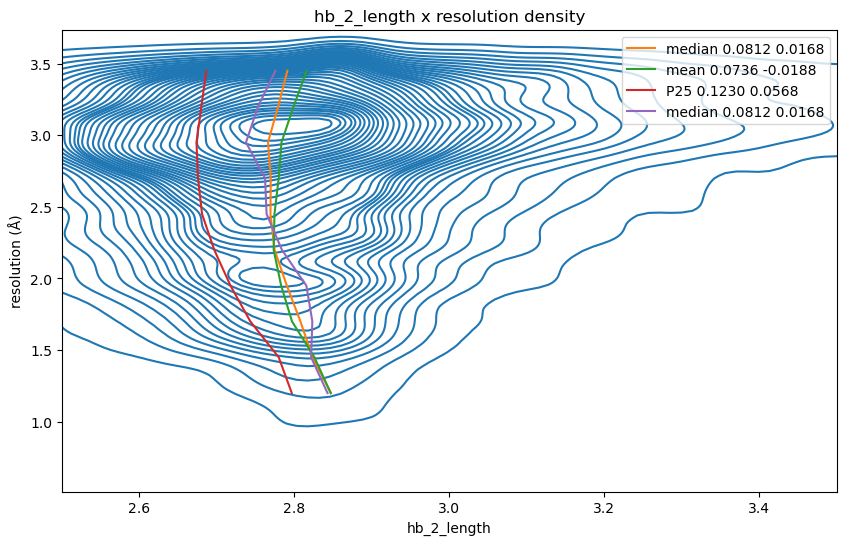

In [9]:

column = "hb_2_length"
stats: dict[str, typing.Callable[[pl.Series], float]] = {
    "mean": lambda col:float(col.mean()),
    "mean_p90": lambda col: float(col.filter((col < col.quantile(0.95)) & (col > col.quantile(0.05))).mean()),
    "mean_p80": lambda col: float(col.filter((col < col.quantile(0.90)) & (col > col.quantile(0.10))).mean()),
}
def create_stat_quantile(p: float):
    return lambda col: float(col.quantile(p))
def create_stat_mode(bw_factor: float):
    return lambda col:float(mode(col.drop_nulls().to_numpy(), bw_factor=bw_factor))
for p in np.arange(30, 70, 5):
    stats[f"P{p}"] = create_stat_quantile(p / 100)
for p in np.arange(0.5, 3.0, 0.1):
    stats[f"mode_{p:1.1f}"] = create_stat_mode(p)

stat_names = list(stats.keys())

sns.kdeplot(df, levels=40, thresh=0.02, x=column, y="resolution").set(title=f"{column} x resolution density", ylabel="resolution (Å)")
plot_running_stat(lambda df: float(df[column].median()), column, "median")
plot_running_stat(lambda df: float(df[column].mean()), column, "mean")
plot_running_stat(lambda df: float(df[column].quantile(0.25)), column, "P25")
plot_running_stat(lambda df: float(mode(df[column].drop_nulls().to_numpy())), column, "mode")
plt.legend(legend)
plt.xlim(2.5, 3.5)
show()
# sns.histplot(df, x="hb_1_donor_angle", y="resolution").set(title="cWW CG pair H-Bond donor angle", xlabel="C6-N1 · · · N3 H-bond angle (°)", ylabel="resolution (Å)")
# show()
# sns.histplot(df, x="hb_1_acceptor_angle", y="resolution").set(title="cWW CG pair H-Bond acceptor angle", xlabel="C6-N1 · · · N3 H-bond angle (°)", ylabel="resolution (Å)")
# show()
# sns.histplot(df, x="hb_1_length", y="resolution").set(title="cWW CG pair H-Bond length", xlabel="N1 · · · N3 H-bond length (Å)", ylabel="resolution (Å)")
# show()


### Stability of the statistic

Now to the point of chapter 3.2 - comparing the middle-value statistics.
One of our condideration is if the middle value is similar across various structural resolutions.
This is important, because non-canonical basepairs frequently occur in large structures which tend to have suboptimal resolution.

The following two blocks compare various quantiles and KDE mode bandwidths in this regard.
The 0.0 line is the optimum, the plots clearly show that different parameters tend to be stretched in different directions in lower-resolution structures.
We can see that the _"default"_ values of quantile=0.5 and bandwidth adjustment of 1 or 1.5 generally tend to work well.

Best quantile: shape: (1, 4)
┌──────────┬─────────────┬─────────────┬─────────────┐
│ quantile ┆ hb_0_length ┆ hb_1_length ┆ hb_2_length │
│ ---      ┆ ---         ┆ ---         ┆ ---         │
│ f64      ┆ f64         ┆ f64         ┆ f64         │
╞══════════╪═════════════╪═════════════╪═════════════╡
│ 0.4      ┆ -0.107085   ┆ -0.02296    ┆ 0.159596    │
└──────────┴─────────────┴─────────────┴─────────────┘
Mode: {'hb_0_length': -0.022861190379017963, 'hb_1_length': -0.035370843779297285, 'hb_2_length': 0.24560848254239198}


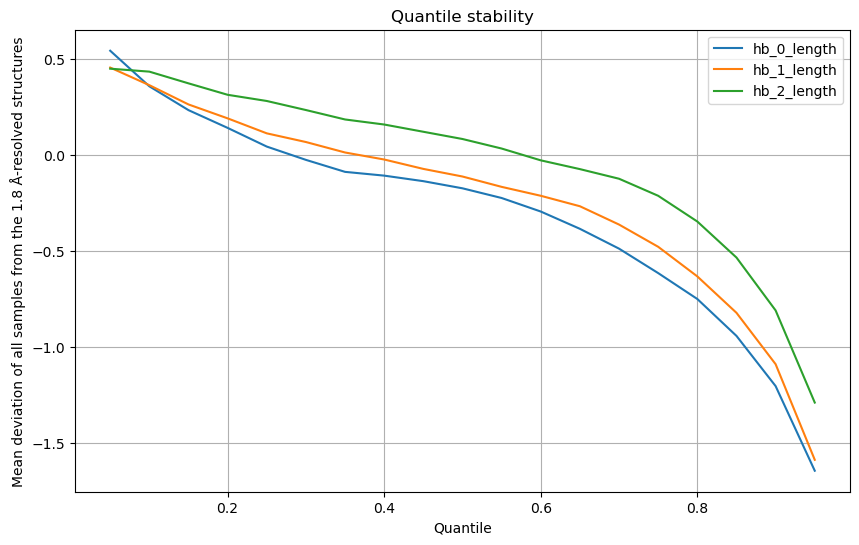

In [13]:
# columns = [ "hb_0_length", "hb_1_length", "hb_2_length", "hb_0_donor_angle", "hb_1_donor_angle", "hb_2_donor_angle", "hb_0_acceptor_angle", "hb_1_acceptor_angle", "hb_2_acceptor_angle" ]
columns = [ "hb_0_length", "hb_1_length", "hb_2_length" ]
data = []
plt.title("Quantile stability")
for quantile in np.arange(0.05, 1, 0.05):
    row = { "quantile": quantile }
    for column in columns:
        row[column] = get_spread(running_stat(lambda df: float(df[column].quantile(quantile))), relative_to=df[column].std())["a18_spread"]
    data.append(row)
data = pl.DataFrame(data)
for column in columns:
    plt.plot(data["quantile"].to_numpy(), data[column].to_numpy())
plt.grid()
plt.legend(columns)
best_quantile = data.sort(pl.sum_horizontal(pl.col(col) ** 2 for col in columns))[0]
print(f"Best quantile: {best_quantile}")
m = {
    col: get_spread(running_stat(lambda df: float(mode(df[col].drop_nulls().to_numpy()))), relative_to=df[col].std())["a18_spread"]
    for col in columns
}
print(f"Mode: {m}")
show()

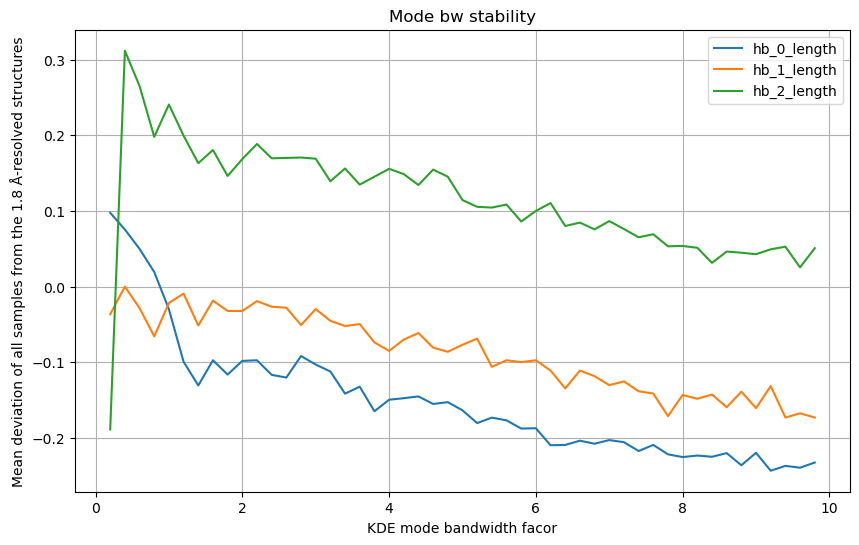

Best bw: 3.2


In [14]:
plt.title("Mode bw stability")
data = []
for bw_factor in np.arange(0.2, 10, 0.2):
    row = { "bw_factor": bw_factor }
    for column in columns:
        row[column] = get_spread(running_stat(lambda df: float(mode(df[column].drop_nulls().to_numpy(), bw_factor))), relative_to=df[column].std())["a18_spread"]
    data.append(row)
data = pl.DataFrame(data)
for column in columns:
    plt.plot(data["bw_factor"].to_numpy(), data[column].to_numpy())
plt.grid()
plt.xlabel("KDE mode bandwidth factor")
plt.ylabel("Mean deviation of all samples from the 1.8 Å-resolved structures")
plt.legend(columns)
show()
best_bw = data.sort(pl.sum_horizontal(pl.col(col) ** 2 for col in columns))["bw_factor"][0]
print(f"Best bw: {best_bw}")

## Stability on smaller sample size

Now we test how stable is the measure on samples of smaller size.
As described in chapter 3.2, we draw 100 samples 1000-times and calculate all tested statistics on all measured parameters.
This block only pre-calculates the values; expect it to run for couple minutes.

In [34]:
# parameters = [ "hb_0_length", "hb_1_length", "hb_2_length", "hb_0_donor_angle", "hb_1_donor_angle", "hb_2_donor_angle", "hb_0_acceptor_angle", "hb_1_acceptor_angle", "hb_2_acceptor_angle" ]
params_lengths = [ "hb_0_length", "hb_1_length", "hb_2_length" ]
params_angles_hb = [ "hb_0_donor_angle", "hb_0_acceptor_angle", "hb_1_donor_angle", "hb_1_acceptor_angle", "hb_2_donor_angle", "hb_2_acceptor_angle" ]
params_angle_hb_plane = ["hb_1_OOPA1", "hb_1_OOPA2", "hb_0_OOPA1", "hb_0_OOPA2", "hb_2_OOPA1", "hb_2_OOPA2" ]
params_angles_plane = [ "C1_C1_yaw1", "C1_C1_pitch1", "C1_C1_roll1", "coplanarity_angle", "coplanarity_edge_angle1" ]
params_plane_shift = [ "coplanarity_shift1", "coplanarity_shift2" ]
all_params_gc = params_lengths + params_angles_hb + params_angle_hb_plane + params_angles_plane + params_plane_shift
all_params_au = params_lengths[:2] + params_angles_hb[:4] + params_angle_hb_plane[:4] + params_angles_plane + params_plane_shift


In [30]:
def bootstrap(df: pl.DataFrame, n: int, params):
    """ Computes all the statistics on all parameter in `n` samples from df"""
    sample = df.sample(n=n) if n < len(df) else df

    stat_matrix = np.zeros((len(params), len(stats)))
    for i, parameter in enumerate(params):
        for j, (stat_name, stat) in enumerate(stats.items()):
            stat_matrix[i, j] = stat(sample[parameter])
    return stat_matrix

def bootstraps(df: pl.DataFrame, n: int, m: int, params):
    """Iterates bootstrap m times"""
    return [ bootstrap(df, n, params) for i in range(0, m) ]

bootstrap_filter = pl.lit(True)
# bootstrap_filter = pl.col("resolution") > 2.5
straps_rna = bootstraps(df.filter(is_rna & bootstrap_filter), 100, 1000, params_lengths)
straps_dna = bootstraps(df.filter(is_dna & bootstrap_filter), 100, 1000, params_lengths)

straps_rna_au = bootstraps(dfAU.filter(is_rna & bootstrap_filter), 100, 1000, params_lengths[:2])
straps_dna_au = bootstraps(dfAU.filter(is_dna & bootstrap_filter), 100, 1000, params_lengths[:2])

total_gc_allparams = bootstrap(df.filter(bootstrap_filter), 1000000000, all_params_gc) 
total_au_allparams = bootstrap(dfAU.filter(bootstrap_filter), 1000000000, all_params_au) 
straps_gc_allparams = bootstraps(df.filter(bootstrap_filter), 100, 1000, all_params_gc)
straps_au_allparams = bootstraps(dfAU.filter(bootstrap_filter), 100, 1000, all_params_au)

KeyboardInterrupt: 

The following chart compares how the calculation on small sample corresponds to the reference H-bond lengths.

(36, 3)
mode_1.3 19 0.022118613239208884
[(array([0.02007765, 0.03755282, 0.09379055]), 'P35', 35.0), (array([0.01337222, 0.02501938, 0.07515232]), 'P40', 40.0), (array([0.02048435, 0.01517818, 0.0568584 ]), 'P45', 45.0), (array([0.0368392 , 0.01119993, 0.0390971 ]), 'P50', 50.0), (array([0.05321777, 0.0140373 , 0.02630338]), 'P55', 55.0), (array([0.07561682, 0.02398833, 0.017132  ]), 'P60', 60.0), (array([0.1010466 , 0.03798362, 0.02065903]), 'P65', 65.0)]


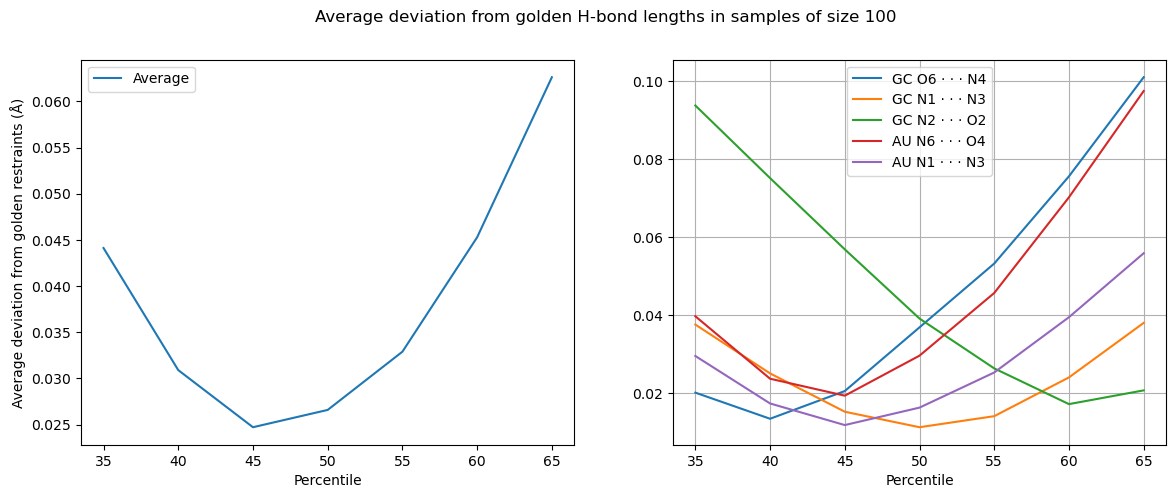

In [ ]:
def calc_gold_deviation(bootstraps, gold):
    return np.mean([ np.abs(boot.T - gold) for boot in bootstraps ], axis=0)

# def calc_self_deviation(bootstraps, parameters):
#     means = np.mean(bootstraps, axis=0)
#     return np.mean([ np.abs(boot - means) for boot in bootstraps ], axis=0)

stat_deviation = np.mean([
    calc_gold_deviation(straps_rna, official_restraints["GC_RNA"]),
    calc_gold_deviation(straps_dna, official_restraints["GC_DNA"])
], axis=0)
print(stat_deviation.shape)
# print(stat_deviation)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

modes = [ (stat_deviation[i], stat_names[i], float(parsed.group(1))) for i in range(len(stat_names)) if (parsed := re.match(r"^P(\d+(\.\d+)?)$", stat_names[i])) if 30 < float(parsed.group(1)) < 70 ]

ax[1].plot([ mode[2] for mode in modes ], [ mode[0] for mode in modes ])

stat_deviation_au = np.mean([
    calc_gold_deviation(straps_rna_au, official_restraints["AU_RNA"]),
    calc_gold_deviation(straps_dna_au, official_restraints["AT_DNA"])
], axis=0)
modes_au = [ (stat_deviation_au[i], stat_names[i], float(parsed.group(1))) for i in range(len(stat_names)) if (parsed := re.match(r"^P(\d+(\.\d+)?)$", stat_names[i])) if 30 < float(parsed.group(1)) < 70 ]
stat_deviation_mean = np.mean([ np.mean(stat_deviation, axis=1), np.mean(stat_deviation_au, axis=1) ], axis=0)
# print(stat_deviation_mean)
# assert False
print(stat_names[np.argmin(stat_deviation_mean)], np.argmin(stat_deviation_mean), np.min(stat_deviation_mean))

print(modes)
plt.xlabel("KDE Bandwidth factor")
ax[1].plot([ mode[2] for mode in modes_au ], [ mode[0] for mode in modes_au ])
ax[1].legend([ "GC O6 · · · N4", "GC N1 · · · N3", "GC N2 · · · O2", "AU N6 · · · O4", "AU N1 · · · N3" ])
ax[0].plot([ mode[2] for mode in modes ], [ np.mean([*modes[i][0], *modes_au[i][0]]) for i in range(len(modes)) ])
ax[0].legend([ "Average" ])
plt.suptitle("Average deviation from golden H-bond lengths in samples of size 100")
ax[1].set(xlabel ="Percentile")
ax[0].set(xlabel ="Percentile", ylabel="Average deviation from golden restraints (Å)")
plt.grid()
fig.savefig("plots/average_deviation.svg")
show()

Now we finally compare all parameter between small (100) subsample and the entire dataset (~50k).
To meaningfully combine them, we normalize the value of each parameter by its standard deviation.

('hb_0_length', np.float64(0.01985412973957211)) ('hb_1_length', np.float64(0.011611908382712803)) ('hb_2_length', np.float64(0.017743056349522682)) ('hb_0_donor_angle', np.float64(0.5761488608551173)) ('hb_0_acceptor_angle', np.float64(0.6510982885844262)) ('hb_1_donor_angle', np.float64(0.5732567473305828)) ('hb_1_acceptor_angle', np.float64(0.5792510221707453)) ('hb_2_donor_angle', np.float64(0.603438733999286)) ('hb_2_acceptor_angle', np.float64(0.6932910750315675)) ('hb_1_donor_OOPA', np.float64(0.7701588347218016)) ('hb_1_acceptor_OOPA', np.float64(1.0644990611335055)) ('hb_0_donor_OOPA', np.float64(1.174555013399168)) ('hb_0_acceptor_OOPA', np.float64(1.1384662835131705)) ('hb_2_donor_OOPA', np.float64(1.0288776778659579)) ('hb_2_acceptor_OOPA', np.float64(1.4344623141338655)) ('C1_C1_yaw1', np.float64(0.5200377741906838)) ('C1_C1_pitch1', np.float64(1.0119556491527957)) ('C1_C1_roll1', np.float64(1.2667410611192294)) ('coplanarity_angle', np.float64(1.0176731661935898)) ('copla

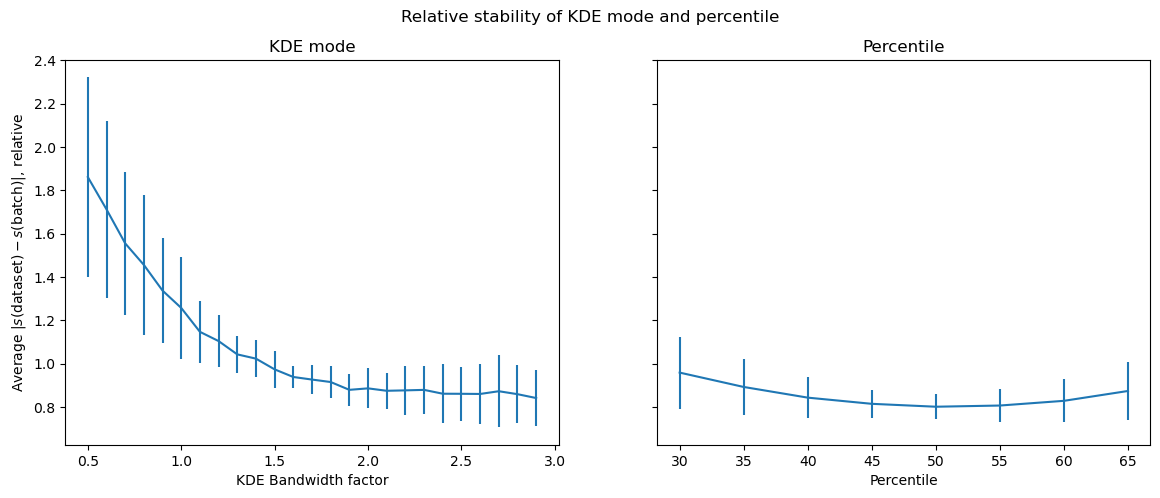

In [19]:
percentiles = [ (i, stat_names[i], float(parsed.group(1))) for i in range(len(stat_names)) if (parsed := re.match(r"^P(\d+(\.\d+)?)$", stat_names[i])) ]
modes = [ (i, stat_names[i], float(parsed.group(1))) for i in range(len(stat_names)) if (parsed := re.match(r"^mode_(\d+(\.\d+)?)$", stat_names[i])) ]

def calc_variance(bootstraps, globals):
    return np.mean([ np.abs(boot - globals) for boot in bootstraps ], axis=0)

# def base_value(param, mean):
#     if "angle" in param or "OOPA" in param  or "euler" in param or "yaw" in param or "pitch" in param or "roll" in param:
#         return 180
#     elif "length" in param:
#         return mean
#     elif "shift" in param:
#         return 3
#     else: assert False, f"Unknown parameter {param}"

# base_gc = [ base_value(param, total_gc_allparams[i, 0]) for i, param in enumerate(all_params_gc) ]
# base_au = [ base_value(param, total_au_allparams[i, 0]) for i, param in enumerate(all_params_au) ]


deviations_gc = calc_variance(straps_gc_allparams, total_gc_allparams)
print(*zip(all_params_gc, np.mean(deviations_gc, axis=1)))
deviations_au = calc_variance(straps_au_allparams, total_au_allparams)
print(*zip(all_params_au, np.mean(deviations_au, axis=1)))
deviations = np.concatenate([
    deviations_gc.T / np.mean(deviations_gc, axis=1), # norm by mean deviance
    deviations_au.T / np.mean(deviations_au, axis=1)
], axis=1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
# ax[0].plot(np.mean(np.concatenate([
#     deviations_gc.T / deviations_gc[:, 20],
#     deviations_au.T / deviations_au[:, 20]
# ], axis=1), axis=1))


# print(np.mean(deviations[[i for i, _, _ in modes ], :], axis=1))
# ax[0].plot([m for _, _, m in modes ], np.mean(deviations[[i for i, _, _ in modes ], :], axis=1))
ax[0].errorbar([m for _, _, m in modes ], np.mean(deviations[[i for i, _, _ in modes ], :], axis=1), yerr=np.std(deviations[[i for i, _, _ in modes ], :], axis=1))
ax[0].set(xlabel ="KDE Bandwidth factor", ylabel="Average $|s(\\mathrm{dataset}) - s(\\mathrm{batch})|$, relative", title="KDE mode")
ax[1].set(xlabel ="Percentile", title="Percentile")
# ax[0].legend([ "" ])


# ax[1].plot([m for _, _, m in percentiles ], np.mean(deviations[[i for i, _, _ in percentiles ], :], axis=1))
ax[1].errorbar([m for _, _, m in percentiles ], np.mean(deviations[[i for i, _, _ in percentiles ], :], axis=1), yerr=np.std(deviations[[i for i, _, _ in percentiles ], :], axis=1))
fig.suptitle("Relative stability of KDE mode and percentile")
# ax[1].plot()
fig.savefig("plots/relative_stability.svg")

In [12]:
sample_sizes = np.concatenate([ np.arange(1000, 200, -50), np.arange(200, 50, -10), np.arange(50, 10, -5) ])
sample_size_stat_matrix = np.zeros((len(sample_sizes), 60, len(all_params_gc), 2))
for i, sample_size in enumerate(sample_sizes):
    for j in range(60):
        sample = df.sample(sample_size)
        for k, param in enumerate(all_params_gc):
            sample_size_stat_matrix[i, j, k, 0] = mode(sample[param].drop_nulls().to_numpy(), bw_factor=1.5)
            sample_size_stat_matrix[i, j, k, 1] = sample[param].median()
# sample_size_stat_matrix

['hb_0_length', 'hb_1_length', 'hb_2_length', 'hb_0_donor_angle', 'hb_0_acceptor_angle', 'hb_1_donor_angle', 'hb_1_acceptor_angle', 'hb_2_donor_angle', 'hb_2_acceptor_angle', 'hb_1_donor_OOPA', 'hb_1_acceptor_OOPA', 'hb_0_donor_OOPA', 'hb_0_acceptor_OOPA', 'hb_2_donor_OOPA', 'hb_2_acceptor_OOPA', 'C1_C1_yaw1', 'C1_C1_pitch1', 'C1_C1_roll1', 'coplanarity_angle', 'coplanarity_edge_angle1', 'coplanarity_shift1', 'coplanarity_shift2']
(39, 22, 2) (39, 22, 2) (39, 2) (39, 2)


Text(0, 0.5, 'Relative deviation, normalized on the 500-1000 samples')

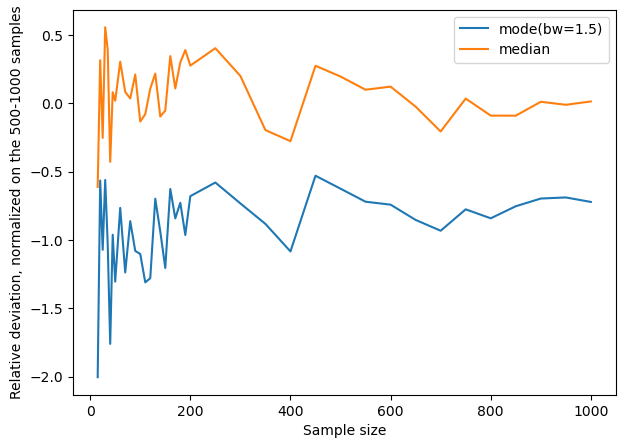

In [76]:
sample1000_metrics = np.mean(sample_size_stat_matrix[0, :, :, :], axis=(0))
# print(modes)
# print(sample1000_metrics)
# print(total_gc_allparams[:, [21, 7]])

sample_size_deviation = \
    np.mean([ (sample_size_stat_matrix - total_gc_allparams[:, [21, 7]]) for sample_size_stat_matrix in sample_size_stat_matrix ], axis=1)
sample_size_deviation_normalized = sample_size_deviation / np.broadcast_to(np.transpose([np.mean(np.mean(np.abs(sample_size_deviation[0:10, ...]), axis=2), axis=0)]), (len(all_params_gc), 2))
# print(sample_size_deviation_normalized[0])
print(all_params_gc)
print(sample_size_deviation.shape, sample_size_deviation_normalized.shape, np.mean(sample_size_deviation_normalized, axis=1).shape, np.std(sample_size_deviation_normalized, axis=1).shape)
plt.subplots(1, 1, figsize=(7, 5))
for i in range(2):
    plt.errorbar(
        sample_sizes,
        np.mean(sample_size_deviation_normalized[:, :, i], axis=1),
        # yerr=np.std(sample_size_deviation_normalized[:, :, i], axis=1),
        # yerr=(
        #     np.quantile(sample_size_deviation_normalized[:, :, i], 0.10, axis=1),
        #     np.quantile(sample_size_deviation_normalized[:, :, i], 0.90, axis=1)
        # )
    )
plt.legend([ "mode(bw=1.5)", "median" ])
plt.xlabel("Sample size")
plt.ylabel("Relative deviation, normalized on 500-1000 samples")

[2.9224     2.89689994 2.7737    ]
[2.93263   2.8975979 2.7778416]


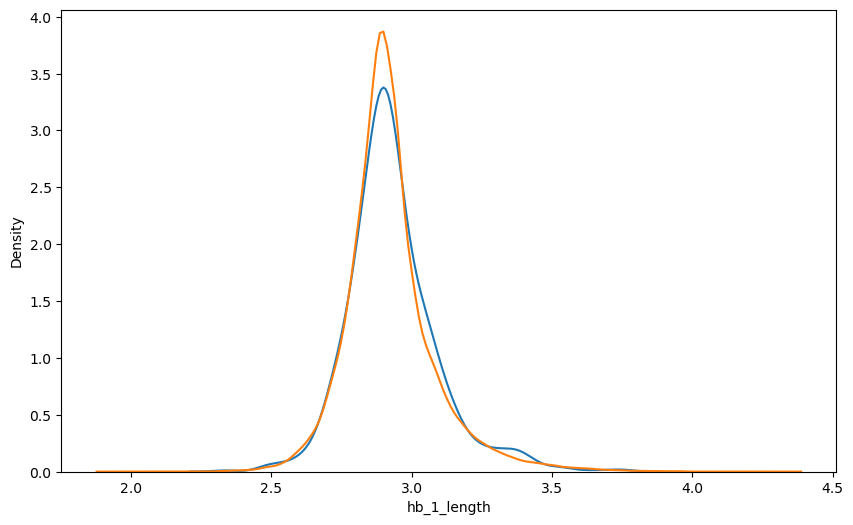

In [73]:
# print(percentiles)
# sns.histplot([
#     [ xx[0, 21] - total_gc_allparams[0, 21] for xx in straps_gc_allparams ],
#     [ xx[0, 7] - total_gc_allparams[0, 7] for xx in straps_gc_allparams ]
# ])
# print(np.mean([ xx[0, 21] - total_gc_allparams[0, 21] for xx in straps_gc_allparams ]), np.mean([ xx[0, 7] - total_gc_allparams[0, 7] for xx in straps_gc_allparams ]))
# print([ xx[0, 21] for xx in straps_gc_allparams])

# sns.kdeplot(df.sample(1000), x="hb_1_length")
# sns.kdeplot(df, x="hb_1_length")
# print(total_gc_allparams[[0, 1, 2], 21])
# print(np.mean([ xx[[0, 1, 2], 21] for xx in straps_gc_allparams ], axis=0))


In [46]:
dfWithN = pl.concat([df.slice(0, 4000), dfN.slice(0, 1000)])
b1 = bootstrap(dfWithN, 1000000, all_params_gc)

('hb_0_length', np.float64(0.014417540642956417)) ('hb_1_length', np.float64(0.00894915607510998)) ('hb_2_length', np.float64(0.0072628601658961305)) ('hb_0_donor_angle', np.float64(0.2150108243441776)) ('hb_0_acceptor_angle', np.float64(0.17822965269725483)) ('hb_1_donor_angle', np.float64(0.20320533170011343)) ('hb_1_acceptor_angle', np.float64(0.2528613635798259)) ('hb_2_donor_angle', np.float64(0.16576308451174804)) ('hb_2_acceptor_angle', np.float64(0.2603119798993679)) ('hb_1_OOPA1', np.float64(0.35386093319580014)) ('hb_1_OOPA2', np.float64(0.4311547953841208)) ('hb_0_OOPA1', np.float64(9.00166918799841)) ('hb_0_OOPA2', np.float64(9.164805363812782)) ('hb_2_OOPA1', np.float64(0.40650215035754145)) ('hb_2_OOPA2', np.float64(0.48016607130794775)) ('C1_C1_yaw1', np.float64(38.74935950607468)) ('C1_C1_pitch1', np.float64(1.661003864437074)) ('C1_C1_roll1', np.float64(158.06408016114358)) ('coplanarity_angle', np.float64(0.6118386030439054)) ('coplanarity_edge_angle1', np.float64(0.2

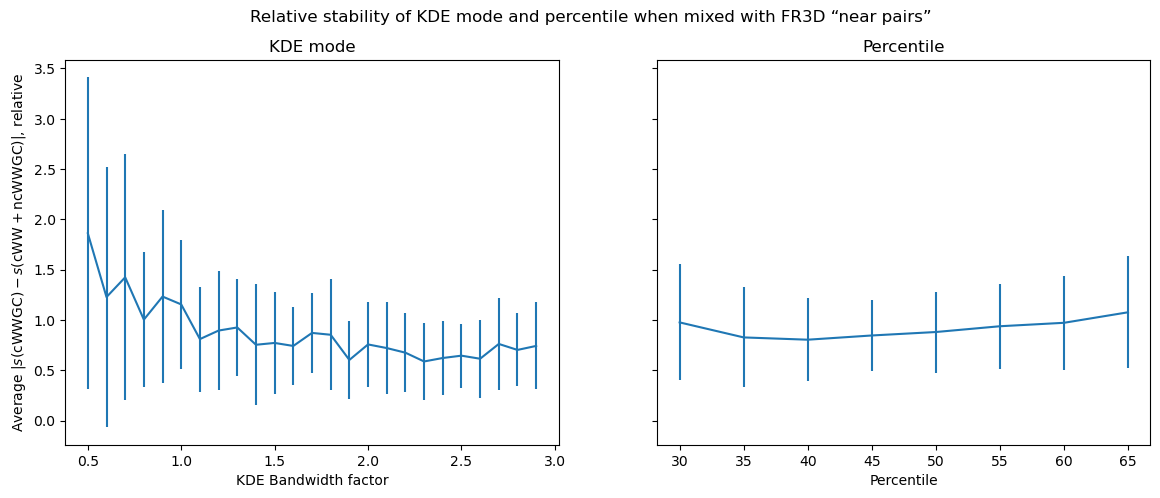

In [47]:
deviations_ngc = np.abs(b1 - total_gc_allparams)
print(*zip(all_params_gc, np.mean(deviations_ngc, axis=1)))
deviations_ngc_rel = deviations_ngc.T / np.mean(deviations_ngc, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
# ax[0].plot(np.mean(np.concatenate([
#     deviations_gc.T / deviations_gc[:, 20],
#     deviations_au.T / deviations_au[:, 20]
# ], axis=1), axis=1))


# print(np.mean(deviations[[i for i, _, _ in modes ], :], axis=1))
# ax[0].plot([m for _, _, m in modes ], np.mean(deviations[[i for i, _, _ in modes ], :], axis=1))
ax[0].errorbar([m for _, _, m in modes ], np.mean(deviations_ngc_rel[[i for i, _, _ in modes ], :], axis=1), yerr=np.std(deviations_ngc_rel[[i for i, _, _ in modes ], :], axis=1))
ax[0].set(xlabel = "KDE Bandwidth factor", ylabel="Average $|s(\\mathrm{cWW GC}) - s(\\mathrm{cWW + ncWW GC})|$, relative", title="KDE mode")
ax[1].set(xlabel = "Percentile", title="Percentile")
# ax[0].legend([ "" ])


# ax[1].plot([m for _, _, m in percentiles ], np.mean(deviations[[i for i, _, _ in percentiles ], :], axis=1))
ax[1].errorbar([m for _, _, m in percentiles ], np.mean(deviations_ngc_rel[[i for i, _, _ in percentiles ], :], axis=1), yerr=np.std(deviations_ngc_rel[[i for i, _, _ in percentiles ], :], axis=1))
fig.suptitle("Relative stability of KDE mode and percentile when mixed with FR3D “near pairs”")
# ax[1].plot()
fig.savefig("plots/relative_stability_ncRR.svg")